In [677]:
import warnings
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')
score = {}

In [2]:
%pwd

'C:\\Users\\RAHUL\\PYTHON Assignment\\Data Science\\2. Walmart Store Sales Forecasting'

In [3]:
features = pd.read_csv('data/features.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')

In [4]:
features.tail(2)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [5]:
train.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True


In [6]:
stores.head(2)

,Store,Type,Size
0,1,A,151315
1,2,A,202307


### Data Preparation

In [7]:
train.shape

(421570, 5)

In [8]:
feat_store = pd.merge(left=features,right=stores,on=['Store'],how='inner')

In [9]:
feat_store.head(3)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315


In [10]:
walmart_train = pd.merge(left=train,right=feat_store,on=['Store','Date'],suffixes=['_train','_feat'])

In [11]:
walmart_train.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday_train,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_feat,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [12]:
walmart_train.shape

(421570, 17)

## Derived Variables

In [13]:
def month_conv(x):
    a = pd.to_datetime(x)
    return a.month

def year_conv(x):
    a = pd.to_datetime(x)
    return a.year

def week_conv(x):
    a = pd.to_datetime(x)
    return a.week

def qtr_conv(x):
    a = pd.to_datetime(x)
    return a.quarter


In [14]:
walmart_train['Month'] = walmart_train['Date'].apply(lambda x: month_conv(x))
walmart_train['Year'] = walmart_train['Date'].apply(lambda x: year_conv(x))
walmart_train['Quarter'] = walmart_train['Date'].apply(lambda x: qtr_conv(x))
walmart_train['Week'] = walmart_train['Date'].apply(lambda x: week_conv(x))

In [15]:
walmart_train.drop(columns=['Date'],inplace=True)

In [16]:
walmart_train.head(3)

,Store,Dept,Weekly_Sales,IsHoliday_train,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_feat,Type,Size,Month,Year,Quarter,Week
0,1,1,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2,2010,1,5
1,1,2,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2,2010,1,5
2,1,3,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2,2010,1,5


### Dummy Categorical Variable 

In [17]:
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=False)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [18]:
vars = ['Store','Type','Dept','Month','Week','Quarter']

for c_feature in vars:
    walmart_train[c_feature] = walmart_train[c_feature].astype('category')
    walmart_train = create_dummies(walmart_train , c_feature )
    
walmart_train.head(3)

,Weekly_Sales,IsHoliday_train,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,...,Week_47,Week_48,Week_49,Week_50,Week_51,Week_52,Quarter_1,Quarter_2,Quarter_3,Quarter_4
0,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,...,0,0,0,0,0,0,1,0,0,0
1,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,...,0,0,0,0,0,0,1,0,0,0
2,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,...,0,0,0,0,0,0,1,0,0,0


In [19]:
walmart_train.head(3)

,Weekly_Sales,IsHoliday_train,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,...,Week_47,Week_48,Week_49,Week_50,Week_51,Week_52,Quarter_1,Quarter_2,Quarter_3,Quarter_4
0,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,...,0,0,0,0,0,0,1,0,0,0
1,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,...,0,0,0,0,0,0,1,0,0,0
2,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,...,0,0,0,0,0,0,1,0,0,0


In [20]:
walmart_train.columns

Index(['Weekly_Sales', 'IsHoliday_train', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       ...
       'Week_47', 'Week_48', 'Week_49', 'Week_50', 'Week_51', 'Week_52',
       'Quarter_1', 'Quarter_2', 'Quarter_3', 'Quarter_4'],
      dtype='object', length=211)

In [21]:
walmart_train.drop(columns=['IsHoliday_feat'],inplace=True)

In [22]:
walmart_train.head(3)

,Weekly_Sales,IsHoliday_train,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,...,Week_47,Week_48,Week_49,Week_50,Week_51,Week_52,Quarter_1,Quarter_2,Quarter_3,Quarter_4
0,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,...,0,0,0,0,0,0,1,0,0,0
1,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,...,0,0,0,0,0,0,1,0,0,0
2,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,...,0,0,0,0,0,0,1,0,0,0


## Variable Analysis

In [23]:
walmart_train.dtypes

Weekly_Sales       float64
IsHoliday_train       bool
Temperature        float64
Fuel_Price         float64
MarkDown1          float64
MarkDown2          float64
MarkDown3          float64
MarkDown4          float64
MarkDown5          float64
CPI                float64
Unemployment       float64
Size                 int64
Year                 int64
Store_1              uint8
Store_2              uint8
Store_3              uint8
Store_4              uint8
Store_5              uint8
Store_6              uint8
Store_7              uint8
Store_8              uint8
Store_9              uint8
Store_10             uint8
Store_11             uint8
Store_12             uint8
Store_13             uint8
Store_14             uint8
Store_15             uint8
Store_16             uint8
Store_17             uint8
                    ...   
Week_27              uint8
Week_28              uint8
Week_29              uint8
Week_30              uint8
Week_31              uint8
Week_32              uint8
W

In [24]:
def holiday(x):
    if x == True:
        return 1
    else:
        return 0
    
walmart_train['IsHoliday_train'] = walmart_train['IsHoliday_train'].apply(lambda x:holiday(x))

#### Missing Value Treatment

In [25]:
walmart_train.isna().sum()

Weekly_Sales            0
IsHoliday_train         0
Temperature             0
Fuel_Price              0
MarkDown1          270889
MarkDown2          310322
MarkDown3          284479
MarkDown4          286603
MarkDown5          270138
CPI                     0
Unemployment            0
Size                    0
Year                    0
Store_1                 0
Store_2                 0
Store_3                 0
Store_4                 0
Store_5                 0
Store_6                 0
Store_7                 0
Store_8                 0
Store_9                 0
Store_10                0
Store_11                0
Store_12                0
Store_13                0
Store_14                0
Store_15                0
Store_16                0
Store_17                0
                    ...  
Week_27                 0
Week_28                 0
Week_29                 0
Week_30                 0
Week_31                 0
Week_32                 0
Week_33                 0
Week_34     

In [26]:
walmart_train['MarkDown1'] = walmart_train.MarkDown1.fillna(walmart_train.MarkDown1.mean())
walmart_train['MarkDown2'] = walmart_train.MarkDown2.fillna(walmart_train.MarkDown2.mean())
walmart_train['MarkDown3'] = walmart_train.MarkDown3.fillna(walmart_train.MarkDown3.mean())
walmart_train['MarkDown4'] = walmart_train.MarkDown4.fillna(walmart_train.MarkDown4.mean())
walmart_train['MarkDown5'] = walmart_train.MarkDown5.fillna(walmart_train.MarkDown5.mean())
walmart_train.isna().any().sum()

0

#### Outlier Treatment

In [27]:
walmart_train.describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,5.000000,59.974500,291.097000,2079.650000,7612.030000,20205.852500,42845.673000,61201.951000,106479.586000,693099.360000
IsHoliday_train,421570.0,0.070358,0.255750,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
Temperature,421570.0,60.090059,18.447931,-2.060,18.300000,27.310000,33.980000,46.680000,62.090000,74.280000,83.580000,87.270000,92.810000,100.140000
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.565000,2.653000,2.720000,2.933000,3.452000,3.738000,3.917000,4.029000,4.202000,4.468000
MarkDown1,421570.0,7246.420196,4956.920816,0.270,58.340000,709.320000,2565.800000,7246.420196,7246.420196,7246.420196,8624.560000,12407.710000,28177.290000,88646.760000
MarkDown2,421570.0,3334.628621,4867.493911,-265.760,1.500000,22.800000,96.940000,3334.628621,3334.628621,3334.628621,3334.628621,3789.560000,21813.160000,104519.540000
MarkDown3,421570.0,1439.421384,5487.601593,-29.100,0.350000,2.700000,7.170000,115.390000,1439.421384,1439.421384,1439.421384,1439.421384,2083.280000,141630.610000
MarkDown4,421570.0,3383.168256,3560.353127,0.220,14.330000,273.530000,696.470000,3383.168256,3383.168256,3383.168256,3383.168256,5163.630000,16822.460000,67474.850000
MarkDown5,421570.0,4628.975079,3573.795304,135.160,548.020000,1288.810000,2049.020000,4628.975079,4628.975079,4628.975079,5284.630000,7456.150000,15590.530000,108519.280000
CPI,421570.0,171.201947,39.159276,126.064,126.111903,126.496258,128.823806,132.022667,182.318780,212.416993,219.444244,221.941558,225.473509,227.232807


In [28]:
def outlier(x):
    x = x.clip(lower = x.quantile(0.05),upper = x.quantile(0.99))
    return x

In [29]:
walmart_train = walmart_train.apply(lambda x : outlier(x))

In [30]:
walmart_train.describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
Weekly_Sales,421570.0,15656.399045,20780.270682,59.974500,59.974500,59.976975,291.097000,2079.650000,7612.030000,20205.852500,42845.673000,61201.951000,106477.746460,106479.586000
IsHoliday_train,421570.0,0.070358,0.255750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
Temperature,421570.0,60.349561,17.812254,27.310000,27.310000,27.310000,33.980000,46.680000,62.090000,74.280000,83.580000,87.270000,92.810000,92.810000
Fuel_Price,421570.0,3.362772,0.452109,2.653000,2.653000,2.653000,2.720000,2.933000,3.452000,3.738000,3.917000,4.029000,4.202000,4.202000
MarkDown1,421570.0,7130.450735,3847.486183,709.320000,709.320000,709.320000,2565.800000,7246.420196,7246.420196,7246.420196,8624.560000,12407.710000,28177.290000,28177.290000
MarkDown2,421570.0,3120.252131,2687.866354,22.800000,22.800000,22.800000,96.940000,3334.628621,3334.628621,3334.628621,3334.628621,3789.560000,21813.160000,21813.160000
MarkDown3,421570.0,1027.586317,640.139249,2.700000,2.700000,2.700000,7.170000,115.390000,1439.421384,1439.421384,1439.421384,1439.421384,2083.280000,2083.280000
MarkDown4,421570.0,3242.905626,2189.428902,273.530000,273.530000,273.530000,696.470000,3383.168256,3383.168256,3383.168256,3383.168256,5163.630000,16822.460000,16822.460000
MarkDown5,421570.0,4512.486429,1978.865916,1288.810000,1288.810000,1288.810000,2049.020000,4628.975079,4628.975079,4628.975079,5284.630000,7456.150000,15590.530000,15590.530000
CPI,421570.0,171.209142,39.134008,126.496258,126.496258,126.496258,128.823806,132.022667,182.318780,212.416993,219.444244,221.941558,225.473509,225.473509


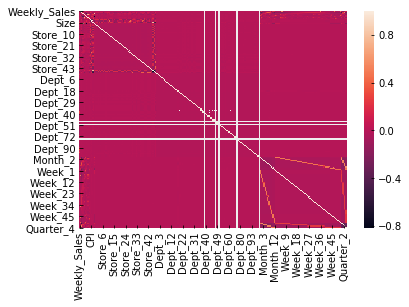

In [31]:
sns.heatmap(walmart_train.corr())

In [119]:
y = walmart_train.Weekly_Sales
var = []
corr_check = {}
for vr in walmart_train.columns:
    if (y.corr(walmart_train[vr]) > 0.05):
        corr_check[vr]= y.corr(walmart_train[vr])
        var.append(vr)
var

['Weekly_Sales',
 'MarkDown1',
 'MarkDown5',
 'Size',
 'Store_2',
 'Store_4',
 'Store_10',
 'Store_13',
 'Store_14',
 'Store_20',
 'Store_27',
 'Type_A',
 'Dept_2',
 'Dept_4',
 'Dept_8',
 'Dept_13',
 'Dept_38',
 'Dept_40',
 'Dept_72',
 'Dept_90',
 'Dept_91',
 'Dept_92',
 'Dept_93',
 'Dept_94',
 'Dept_95']

In [323]:
features = 'Dept_1+Dept_10+Dept_11+Dept_12+Dept_13+Dept_14+Dept_16+Dept_17+Dept_18+Dept_2+Dept_20+Dept_21+Dept_22+Dept_23+Dept_24+Dept_25+Dept_26+Dept_27+Dept_28+Dept_29+Dept_3+Dept_30+Dept_31+Dept_32+Dept_33+Dept_34+Dept_35+Dept_36+Dept_38+Dept_4+Dept_40+Dept_41+Dept_42+Dept_44+Dept_46+Dept_49+Dept_5+Dept_52+Dept_55+Dept_56+Dept_58+Dept_59+Dept_6+Dept_60+Dept_65+Dept_67+Dept_7+Dept_71+Dept_72+Dept_74+Dept_77+Dept_78+Dept_79+Dept_8+Dept_80+Dept_81+Dept_82+Dept_83+Dept_85+Dept_87+Dept_9+Dept_90+Dept_91+Dept_92+Dept_93+Dept_94+Dept_95+Dept_96+Dept_97+Dept_98+Dept_99+Fuel_Price+IsHoliday_train+MarkDown3+MarkDown4+MarkDown5+Month_1+Month_3+Month_5+Month_6+Month_7+Month_8+Month_9+Quarter_1+Quarter_2+Quarter_3+Quarter_4+Store_10+Store_11+Store_13+Store_14+Store_15+Store_16+Store_17+Store_18+Store_2+Store_20+Store_21+Store_22+Store_23+Store_24+Store_25+Store_26+Store_27+Store_29+Store_3+Store_30+Store_31+Store_32+Store_33+Store_34+Store_35+Store_36+Store_37+Store_38+Store_39+Store_4+Store_40+Store_41+Store_42+Store_44+Store_45+Store_5+Store_7+Store_8+Store_9+Temperature+Type_B+Type_C+Unemployment+Week_1+Week_10+Week_11+Week_12+Week_13+Week_14+Week_15+Week_16+Week_17+Week_18+Week_19+Week_20+Week_21+Week_22+Week_26+Week_27+Week_28+Week_29+Week_30+Week_32+Week_33+Week_34+Week_35+Week_36+Week_40+Week_43+Week_44+Week_45+Week_46+Week_48+Week_49+Week_5+Week_52+Week_6+Week_7+Week_8+Week_9+Year'

### Perform F_Regression to check for the Pvalue of each variable with the dependent variable 

In [667]:
#features = 'Dept_1+Dept_10+Dept_11+Dept_12+Dept_13+Dept_14+Dept_16+Dept_17+Dept_18+Dept_2+Dept_20+Dept_21+Dept_22+Dept_23+Dept_24+Dept_25+Dept_26+Dept_27+Dept_28+Dept_29+Dept_3+Dept_30+Dept_31+Dept_32+Dept_33+Dept_34+Dept_35+Dept_36+Dept_38+Dept_4+Dept_40+Dept_41+Dept_42+Dept_44+Dept_46+Dept_49+Dept_5+Dept_52+Dept_55+Dept_56+Dept_58+Dept_59+Dept_6+Dept_60+Dept_65+Dept_67+Dept_7+Dept_71+Dept_72+Dept_74+Dept_77+Dept_78+Dept_79+Dept_8+Dept_80+Dept_81+Dept_82+Dept_83+Dept_85+Dept_87+Dept_9+Dept_90+Dept_91+Dept_92+Dept_93+Dept_94+Dept_95+Dept_96+Dept_97+Dept_98+Dept_99+Fuel_Price+IsHoliday_train+MarkDown3+MarkDown4+MarkDown5+Month_1+Month_3+Month_5+Month_6+Month_7+Month_8+Month_9+Quarter_1+Quarter_2+Quarter_3+Quarter_4+Store_10+Store_11+Store_13+Store_14+Store_15+Store_16+Store_17+Store_18+Store_2+Store_20+Store_21+Store_22+Store_23+Store_24+Store_25+Store_26+Store_27+Store_29+Store_3+Store_30+Store_31+Store_32+Store_33+Store_34+Store_35+Store_36+Store_37+Store_38+Store_39+Store_4+Store_40+Store_41+Store_42+Store_44+Store_45+Store_5+Store_7+Store_8+Store_9+Temperature+Type_B+Type_C+Unemployment+Week_1+Week_10+Week_11+Week_12+Week_13+Week_14+Week_15+Week_16+Week_17+Week_18+Week_19+Week_20+Week_21+Week_22+Week_26+Week_27+Week_28+Week_29+Week_30+Week_31+Week_32+Week_33+Week_34+Week_35+Week_36+Week_37+Week_38+Week_39+Week_40+Week_41+Week_42+Week_43+Week_44+Week_45+Week_46+Week_48+Week_49+Week_5+Week_52+Week_6+Week_7+Week_8+Week_9+Year'
#features = "+".join(['Dept_1','Dept_10','Dept_11','Dept_12','Dept_13','Dept_14','Dept_16','Dept_17','Dept_18','Dept_2','Dept_20','Dept_21','Dept_22','Dept_23','Dept_24','Dept_25','Dept_26','Dept_27','Dept_28','Dept_29','Dept_3','Dept_30','Dept_31','Dept_32','Dept_33','Dept_35','Dept_36','Dept_38','Dept_4','Dept_40','Dept_41','Dept_42','Dept_44','Dept_46','Dept_49','Dept_5','Dept_52','Dept_54','Dept_55','Dept_56','Dept_58','Dept_59','Dept_6','Dept_60','Dept_67','Dept_7','Dept_71','Dept_72','Dept_74','Dept_79','Dept_8','Dept_80','Dept_83','Dept_85','Dept_87','Dept_9','Dept_90','Dept_91','Dept_92','Dept_93','Dept_94','Dept_95','Dept_97','Dept_98','MarkDown4','MarkDown5','Month_1','Month_10','Month_11','Month_12','Month_3','Month_6','Size','Store_10','Store_11','Store_12','Store_13','Store_15','Store_19','Store_2','Store_21','Store_22','Store_23','Store_24','Store_25','Store_26','Store_27','Store_28','Store_29','Store_3','Store_30','Store_31','Store_32','Store_33','Store_34','Store_36','Store_37','Store_38','Store_39','Store_4','Store_40','Store_41','Store_42','Store_43','Store_45','Store_5','Store_6','Store_7','Store_8','Store_9','Type_A','Type_B','Type_C','Unemployment','Week_12','Week_14','Week_17','Week_2','Week_22','Week_27','Week_3','Week_30','Week_31','Week_37','Week_38','Week_39','Week_4','Week_41','Week_42','Week_47','Week_48','Week_50','Week_51','Week_52','Week_7','Week_8','Year'])
features = "+".join(['Dept_1','Dept_10','Dept_11','Dept_12','Dept_13','Dept_14','Dept_16','Dept_17','Dept_18','Dept_2','Dept_20','Dept_21','Dept_22','Dept_23','Dept_24','Dept_25','Dept_26','Dept_27','Dept_28','Dept_29','Dept_3','Dept_30','Dept_31','Dept_32','Dept_33','Dept_35','Dept_36','Dept_4','Dept_40','Dept_41','Dept_42','Dept_44','Dept_46','Dept_49','Dept_5','Dept_52','Dept_54','Dept_55','Dept_56','Dept_58','Dept_59','Dept_6','Dept_60','Dept_67','Dept_7','Dept_71','Dept_72','Dept_74','Dept_79','Dept_8','Dept_80','Dept_83','Dept_85','Dept_87','Dept_9','Dept_90','Dept_91','Dept_93','Dept_94','Dept_97','Dept_98','Month_6','Store_10','Store_11','Store_12','Store_13','Store_15','Store_19','Store_2','Store_21','Store_23','Store_24','Store_25','Store_26','Store_27','Store_28','Store_29','Store_3','Store_30','Store_31','Store_32','Store_34','Store_36','Store_37','Store_38','Store_39','Store_4','Store_40','Store_41','Store_42','Store_43','Store_45','Store_5','Store_6','Store_7','Store_8','Store_9','Week_12','Week_14','Week_17','Week_2','Week_22','Week_27','Week_3','Week_30','Week_4','Week_47','Week_50','Week_51','Week_52','Week_7','Week_8'])
#features = '+'.join(['Store_30','Store_36','Store_25','Dept_25','Dept_49','Dept_79','Store_19','Store_39','Store_37','Dept_5','Store_21','Dept_17','Store_23','Store_45','Store_31','Dept_55','Dept_22','Dept_9','Store_42','Store_11','Dept_46','Week_50','Store_24','Week_47','Dept_3','Dept_1','Store_28','Dept_80','Store_8','Store_34','Store_41','Dept_10','Dept_87','Week_4','Store_40','Store_43','Dept_74','Week_2','Week_3','Year','Dept_97','Dept_16','Week_12','Store_26','Week_8','Week_22','Week_52','Week_30','Store_12','Dept_11','Month_6','Week_17','Store_32','Week_7','Dept_14','Week_14','Week_27','Store_22'])
features1 = features.split('+')

In [649]:
# Feature Selection based on importance
from sklearn.feature_selection import f_regression
#features = train_x[train_x.columns.difference(['Dept_19','Dept_37','Dept_39','Dept_43','Dept_45','Dept_47','Dept_48','Dept_50','Dept_51','Dept_65','Dept_77','Dept_78','Dept_99'])]
X = train_x[features1]
target = train_y
F_values, p_values  = f_regression(X, target )

In [627]:
import itertools
f_reg_results = [(i, v, z) for i, v, z in itertools.zip_longest(X.columns, F_values,  ['%.3f' % p for p in p_values])]

f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])
f_reg_results.to_csv('F_Reg.csv')

In [628]:
f_reg_results.sort_values(by=['P_Value'])

f_reg_results.P_Value = pd.to_numeric(f_reg_results.P_Value)

f_reg_results_new=f_reg_results[f_reg_results.P_Value<=0.1]

f_reg_results_new.to_csv('F_Reg_New.csv')

### Check MultiCollinearity between the Feature Columns

In [611]:
#MUltiple Iteration of Feature Columns based on the previous conversion and removing and checking the Multi Colinnearity Values
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices



a,b = dmatrices('Weekly_Sales~' + features ,data=walmart_train,return_type = 'dataframe')

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(b.values,i) for i in range(b.shape[1])]
vif['features'] = b.columns

In [612]:
vif.sort_values('features',ascending=False)
vif.to_csv('VIF.csv')

### Train Test Split from Walmart_Train Data set

In [668]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [669]:
final_cols = features.split("+")
walmart_train_final = pd.concat([walmart_train[final_cols],walmart_train['Weekly_Sales']],axis=1)


In [670]:
train,test = train_test_split(walmart_train_final,test_size=0.3,random_state=1234)

In [671]:
Y = walmart_train_final['Weekly_Sales']
X = walmart_train_final[final_cols]

In [672]:
train_x, test_x, train_y, test_y = train_test_split(X,Y,test_size = 0.3,random_state = 1234)

In [673]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(295099, 112)
(126471, 112)
(295099,)
(126471,)


## Linear Regression Model Built

 - Model created through Statistical method

In [674]:
lm = smf.ols('Weekly_Sales~' + features,train).fit()

In [675]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     2055.
Date:                Mon, 02 Sep 2019   Prob (F-statistic):               0.00
Time:                        21:36:34   Log-Likelihood:            -3.2672e+06
No. Observations:              295099   AIC:                         6.535e+06
Df Residuals:                  294986   BIC:                         6.536e+06
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.767e+04     97.050    285.145      0.0

 - Model created throughj ML Approach

In [676]:
linreg = LinearRegression()
linreg.fit(train_x,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [678]:
linreg.score(train_x,train_y)

0.4383152548563367

In [679]:
linreg.score(test_x,test_y)

0.43812036114076675

In [680]:
score['Linear_Regression'] = linreg.score(train_x,train_y)

#### Conclusion : Linear Regression

As we can see above, through Linear Regression, the R2 value though is around 0.65, there is strong Multicollinearity between the variables. Hence will try to create different models using other algorithms

### Decision Tree Regressor

In [681]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV 

In [682]:
#parameter = {'max_features' : [50,75,100,125,150,200,250]}          

In [683]:
dtr = DecisionTreeRegressor()

In [684]:
dtr.fit(train_x,train_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [685]:
dtr.score(train_x,train_y)

0.6013817593195127

In [686]:
dtr.score(test_x,test_y)

0.5829512283140947

In [687]:
score['Decision_Tree_Regression'] = dtr.score(train_x,train_y)

### Random Forest Regressor

In [688]:
from sklearn.ensemble import RandomForestRegressor

In [689]:
rdf = RandomForestRegressor()

In [690]:
rdf.fit(train_x,train_y)

C:\Users\RAHUL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [691]:
rdf.score(train_x,train_y)

0.5997955492873348

In [692]:
rdf.score(test_x,test_y)

0.5822182283496603

In [693]:
score['Random_Forest_Regression'] = rdf.score(train_x,train_y)

### Naive Bayessian Ridge Regressor

In [694]:
from sklearn.linear_model import BayesianRidge

In [695]:
bay = BayesianRidge()
bay.fit(train_x,train_y)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [696]:
bay.score(train_x,train_y)

0.43831499689052456

In [697]:
bay.score(test_x,test_y)

0.4381214819610809

In [698]:
score['Bayesian_Ridge_Resression'] = bay.score(train_x,train_y)

### ANN - Artificial Neural Network

In [699]:
walmart_train_final.head(3)

,Dept_1,Dept_10,Dept_11,Dept_12,Dept_13,Dept_14,Dept_16,Dept_17,Dept_18,Dept_2,...,Week_3,Week_30,Week_4,Week_47,Week_50,Week_51,Week_52,Week_7,Week_8,Weekly_Sales
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24924.50
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,50605.27
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13740.12


In [700]:
from sklearn.preprocessing import StandardScaler

In [701]:
X = walmart_train_final[walmart_train_final.columns.difference(['Weekly_Sales'])]
y = walmart_train_final['Weekly_Sales']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3,random_state=1234)

In [702]:
scaler = StandardScaler()
scaler.fit(train_x)

C:\Users\RAHUL\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [703]:
# Now apply the transformations to the data:
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  
C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [704]:
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [727]:
mlp = MLPRegressor(hidden_layer_sizes=500)

In [728]:
mlp.fit(train_x,train_y)

C:\Users\RAHUL\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=500, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [729]:
predictions_test = mlp.predict(test_x)
predictions_train = mlp.predict(train_x)

In [730]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics

In [732]:
metrics.r2_score(test_y,predictions_test)

0.5888151477713403

In [733]:
metrics.r2_score(train_y,predictions_train)

0.5927569560015877

In [734]:
score['ANN'] = metrics.r2_score(train_y,predictions_train)

In [735]:
score = pd.DataFrame(score,index=['0'])

In [736]:
score

,Linear_Regression,Decision_Tree_Regression,Random_Forest_Regression,Bayesian_Ridge_Resression,ANN
0,0.438315,0.601382,0.599796,0.438315,0.592757


#### Based on the above four models - <br><br>
1. The Linear Regression Model and the Bayesian Linear Regression Model had the lowest Co-efficient of Determination : at around 43.8% model accuracy.<br>
2. The Decision Tree Regressor Model had about 60.1% model accuracy (Co-efficient of Determination).  <br>
3. The Random Forest Regressor Model showed 59.97% model accuracy. <br> 
4. The ANN Regressor Model showed 59.27% model accuracy. <br> 

#### Based on all of this the Decision Tree Regressor is found to have the best accuracy with optimal time to build the model
====================================================================================================================


In [353]:
test_data = pd.read_csv('data/test.csv')

In [354]:
walmart_test = pd.merge(left=test_data,right=feat_store,on=['Store','Date'],suffixes=['_train','_feat'])

In [355]:
test_data.head(3)

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False


In [356]:
walmart_test.shape

(115064, 16)

In [357]:
walmart_test['Month'] = walmart_test['Date'].apply(lambda x: month_conv(x))
walmart_test['Year'] = walmart_test['Date'].apply(lambda x: year_conv(x))
walmart_test['Quarter'] = walmart_test['Date'].apply(lambda x: qtr_conv(x))
walmart_test['Week'] = walmart_test['Date'].apply(lambda x: week_conv(x))

In [358]:
walmart_test.drop(columns=['Date'],inplace=True)

In [359]:
vars = ['Store','Type','Dept','Month','Week','Quarter']

for c_feature in vars:
    walmart_test[c_feature] = walmart_test[c_feature].astype('category')
    walmart_test = create_dummies(walmart_test , c_feature )
    
walmart_test.head(3)

,IsHoliday_train,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,...,Week_47,Week_48,Week_49,Week_50,Week_51,Week_52,Quarter_1,Quarter_2,Quarter_3,Quarter_4
0,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,...,0,0,0,0,0,0,0,0,0,1
1,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,...,0,0,0,0,0,0,0,0,0,1
2,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,...,0,0,0,0,0,0,0,0,0,1


In [360]:
walmart_test['IsHoliday_train'] = walmart_test['IsHoliday_train'].apply(lambda x:holiday(x))

In [361]:
walmart_test['CPI'] = walmart_test.CPI.fillna(walmart_test.CPI.mean())
walmart_test['Unemployment'] = walmart_test.Unemployment.fillna(walmart_test.Unemployment.mean())
walmart_test['MarkDown1'] = walmart_test.MarkDown1.fillna(walmart_test.MarkDown1.mean())
walmart_test['MarkDown2'] = walmart_test.MarkDown2.fillna(walmart_test.MarkDown2.mean())
walmart_test['MarkDown3'] = walmart_test.MarkDown3.fillna(walmart_test.MarkDown3.mean())
walmart_test['MarkDown4'] = walmart_test.MarkDown4.fillna(walmart_test.MarkDown4.mean())
walmart_test['MarkDown5'] = walmart_test.MarkDown5.fillna(walmart_test.MarkDown5.mean())
walmart_test.isna().any().sum()

0

In [362]:
walmart_test = walmart_test.apply(lambda x : outlier(x))

In [365]:
walmart_test.shape

(115064, 194)

In [714]:
walmart_test_final = walmart_test[final_cols]

In [715]:
walmart_test_final['Weekly_Sales'] = dtr.predict(walmart_test_final)

C:\Users\RAHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [717]:
walmart_test_final.to_csv('walmart_test_final.csv')

In [718]:
walmart_test_final.Weekly_Sales.min()

59.97449999999999

In [719]:
walmart_test_final.Weekly_Sales.max()

106479.586

In [726]:
walmart_test_final.Weekly_Sales.std()

16412.175437818743

In [723]:
walmart_train.Weekly_Sales.min()

59.974500000000006

In [724]:
walmart_train.Weekly_Sales.max()

106479.58599999998

In [725]:
walmart_train.Weekly_Sales.std()

20780.270682340608